# Section 1 - Question 2: Initialization, Threshold, and Convergence
In this part, we explore how *initial weights*, *bias initialization*, *learning rate (η)*, and *threshold (θ)*
affect the **Perceptron learning process**.

We will:
1. Load letter-shaped `.txt` data (A–K).
2. Implement a binary Perceptron (A vs not-A).
3. Test 5 initialization methods: `zeros`, `uniform`, `normal`, `xavier`, `kaiming`.
4. Sweep through multiple `θ` and `η` values.
5. Plot *training error rate vs epoch*.
6. Report *final train/test error*, *epochs to converge*, and *time* for each setup.


In [2]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
def read_char(path):
    """Convert a text file (9x7 character image) into a 1D binary vector."""
    with open(path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    data = np.array([[1 if c == '#' else 0 for c in line] for line in lines], dtype=float)
    return data.flatten()

def load_dataset(folder):
    """
    Load dataset of character text files.
    A → label +1
    others → label -1
    """
    X, y, names = [], [], []
    for fname in sorted(os.listdir(folder)):
        if not fname.endswith(".txt"):
            continue
        label = fname[0].upper()
        target = 1 if label == 'A' else -1
        x = read_char(os.path.join(folder, fname))
        X.append(x)
        y.append(target)
        names.append(fname)
    return np.array(X), np.array(y), names


In [4]:
def init_weights(mode, dim, seed=None):
    rng = np.random.default_rng(seed)
    if mode == "zeros":
        return np.zeros(dim), 0.0
    elif mode == "uniform":
        return rng.uniform(-0.5, 0.5, dim), float(rng.uniform(-0.5, 0.5))
    elif mode == "normal":
        return rng.normal(0, 0.01, dim), float(rng.normal(0, 0.01))
    elif mode == "xavier":
        std = np.sqrt(2.0 / (dim + 1.0))
        return rng.normal(0, std, dim), float(rng.normal(0, std))
    elif mode == "kaiming":
        std = np.sqrt(2.0 / dim)
        return rng.normal(0, std, dim), float(rng.normal(0, std))
    else:
        raise ValueError("Unknown initialization mode")


In [5]:
def train_one_epoch(X, y, w, b, lr, theta=0.0):
    """Train for one epoch and return updated weights, bias, and error info."""
    errors = 0
    for xi, target in zip(X, y):
        z = np.dot(w, xi) + b
        y_pred = 1 if z >= theta else -1
        if y_pred != target:
            w += lr * target * xi
            b += lr * target
            errors += 1
    # compute epoch error rate
    preds = np.where(np.dot(X, w.T) + b >= theta, 1, -1)
    error_rate = np.mean(preds != y)
    return w, b, errors, error_rate


def train_perceptron(X, y, w_init, b_init, lr=0.1, theta=0.0, max_epochs=100):
    """Train for multiple epochs and record errors per epoch."""
    w, b = w_init.copy(), float(b_init)
    epoch_updates, epoch_errors = [], []
    start_time = time.time()
    converged_epoch = None

    for epoch in range(1, max_epochs + 1):
        w, b, updates, err_rate = train_one_epoch(X, y, w, b, lr, theta)
        epoch_updates.append(updates)
        epoch_errors.append(err_rate)
        if updates == 0 and converged_epoch is None:
            converged_epoch = epoch
            break

    elapsed = time.time() - start_time
    return {
        "w": w, "b": b,
        "epoch_updates": epoch_updates,
        "epoch_errors": epoch_errors,
        "converged_epoch": converged_epoch or max_epochs,
        "elapsed": elapsed
    }


In [6]:
def run_experiments(train_folder="Characters-TrainSet",
                    test_folder="Characters-TestSet",
                    theta_list=[-1.0, -0.5, 0.0, 0.5, 1.0],
                    eta_list=[0.01, 0.05, 0.1, 0.5],
                    init_modes=["zeros","uniform","normal","xavier","kaiming"],
                    max_epochs=30,
                    seed_base=123):
    
    X_train, y_train, _ = load_dataset(train_folder)
    X_test, y_test, _ = load_dataset(test_folder)
    dim = X_train.shape[1]
    results = defaultdict(list)

    for i_mode, mode in enumerate(init_modes):
        for theta in theta_list:
            for eta in eta_list:
                seed = seed_base + i_mode*100 + int(eta*100)
                w0, b0 = init_weights(mode, dim, seed)
                result = train_perceptron(X_train, y_train, w0, b0, lr=eta, theta=theta, max_epochs=max_epochs)

                # Evaluate final model
                y_pred_train = np.where(np.dot(X_train, result["w"]) + result["b"] >= theta, 1, -1)
                y_pred_test  = np.where(np.dot(X_test, result["w"])  + result["b"] >= theta, 1, -1)
                train_err = np.mean(y_pred_train != y_train)
                test_err = np.mean(y_pred_test != y_test)

                results[mode].append({
                    "theta": theta,
                    "eta": eta,
                    "train_err": train_err,
                    "test_err": test_err,
                    "converged_epoch": result["converged_epoch"],
                    "elapsed": result["elapsed"],
                    "epoch_errors": result["epoch_errors"]
                })
                print(f"{mode:7s} θ={theta:+.2f} η={eta:.2f} → train={train_err*100:5.2f}% test={test_err*100:5.2f}% conv={result['converged_epoch']} time={result['elapsed']:.3f}s")
    return results


In [7]:
theta_values = [-1.0, -0.5, 0.0, 0.5, 1.0]
eta_values   = [0.01, 0.05, 0.1, 0.5]
init_modes   = ["zeros", "uniform", "normal", "xavier", "kaiming"]

results = run_experiments(
    train_folder="Characters-TrainSet",
    test_folder="Characters-TestSet",
    theta_list=theta_values,
    eta_list=eta_values,
    init_modes=init_modes,
    max_epochs=20
)


zeros   θ=-1.00 η=0.01 → train= 0.00% test=19.05% conv=5 time=0.000s
zeros   θ=-1.00 η=0.05 → train= 0.00% test= 4.76% conv=3 time=0.000s
zeros   θ=-1.00 η=0.10 → train= 0.00% test= 0.00% conv=3 time=0.000s
zeros   θ=-1.00 η=0.50 → train= 0.00% test= 4.76% conv=4 time=0.000s
zeros   θ=-0.50 η=0.01 → train= 0.00% test= 4.76% conv=4 time=0.000s
zeros   θ=-0.50 η=0.05 → train= 0.00% test= 0.00% conv=3 time=0.005s
zeros   θ=-0.50 η=0.10 → train= 0.00% test= 9.52% conv=3 time=0.000s
zeros   θ=-0.50 η=0.50 → train= 0.00% test= 4.76% conv=3 time=0.000s
zeros   θ=+0.00 η=0.01 → train= 0.00% test= 4.76% conv=3 time=0.000s
zeros   θ=+0.00 η=0.05 → train= 0.00% test= 4.76% conv=3 time=0.000s
zeros   θ=+0.00 η=0.10 → train= 0.00% test= 4.76% conv=3 time=0.000s
zeros   θ=+0.00 η=0.50 → train= 0.00% test= 4.76% conv=3 time=0.000s
zeros   θ=+0.50 η=0.01 → train= 0.00% test= 4.76% conv=4 time=0.000s
zeros   θ=+0.50 η=0.05 → train= 0.00% test= 0.00% conv=4 time=0.001s
zeros   θ=+0.50 η=0.10 → train= 0.

In [8]:
def plot_error_curves(results, init_mode, theta_values, eta_values, max_epochs=20):
    """Plot training error curves for a given initialization mode."""
    records = results[init_mode]
    grouped = {eta: [] for eta in eta_values}
    for rec in records:
        grouped[rec["eta"]].append((rec["theta"], rec["epoch_errors"]))

    nrows = len(eta_values)
    fig, axs = plt.subplots(nrows=nrows, figsize=(6, 3*nrows), sharex=True)
    if nrows == 1:
        axs = [axs]
    for i, eta in enumerate(sorted(eta_values)):
        ax = axs[i]
        for theta, errs in sorted(grouped[eta], key=lambda x: x[0]):
            epochs = np.arange(1, len(errs)+1)
            ax.plot(epochs, errs, marker='o', label=f"θ={theta:+.2f}")
        ax.set_title(f"{init_mode} | η={eta}")
        ax.set_ylabel("Train Error Rate")
        ax.legend()
        ax.grid(True, linestyle=':')
    axs[-1].set_xlabel("Epoch")
    plt.tight_layout()
    plt.show()


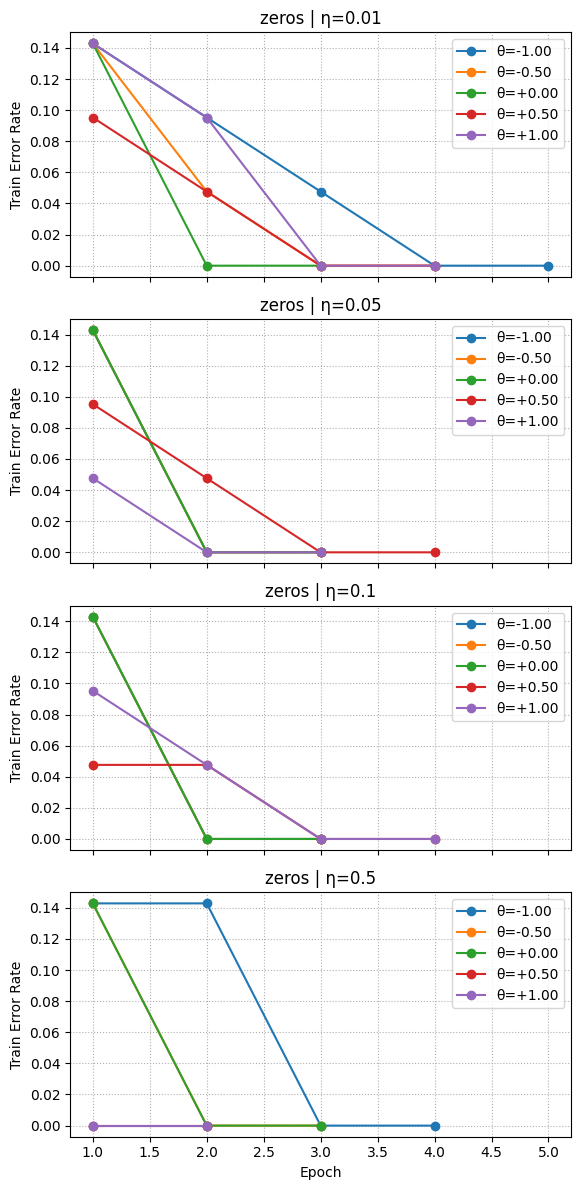

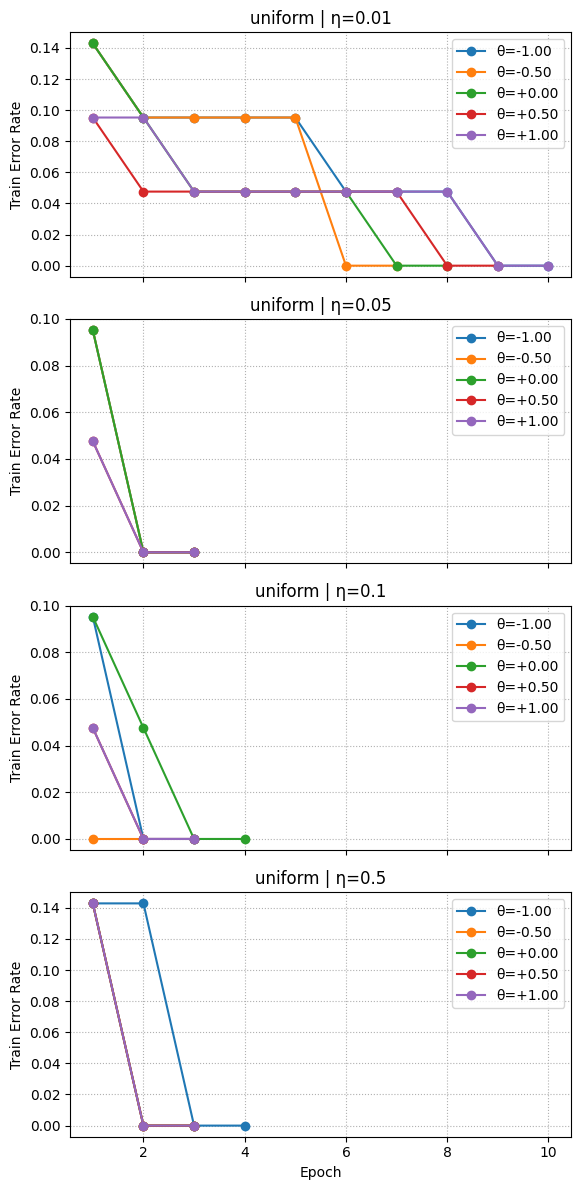

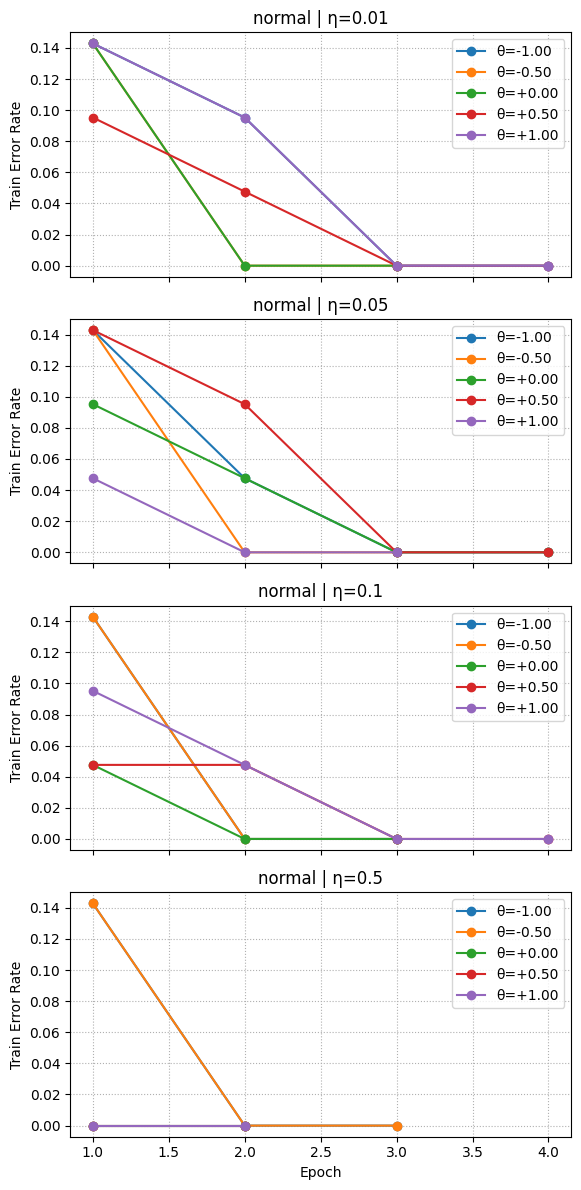

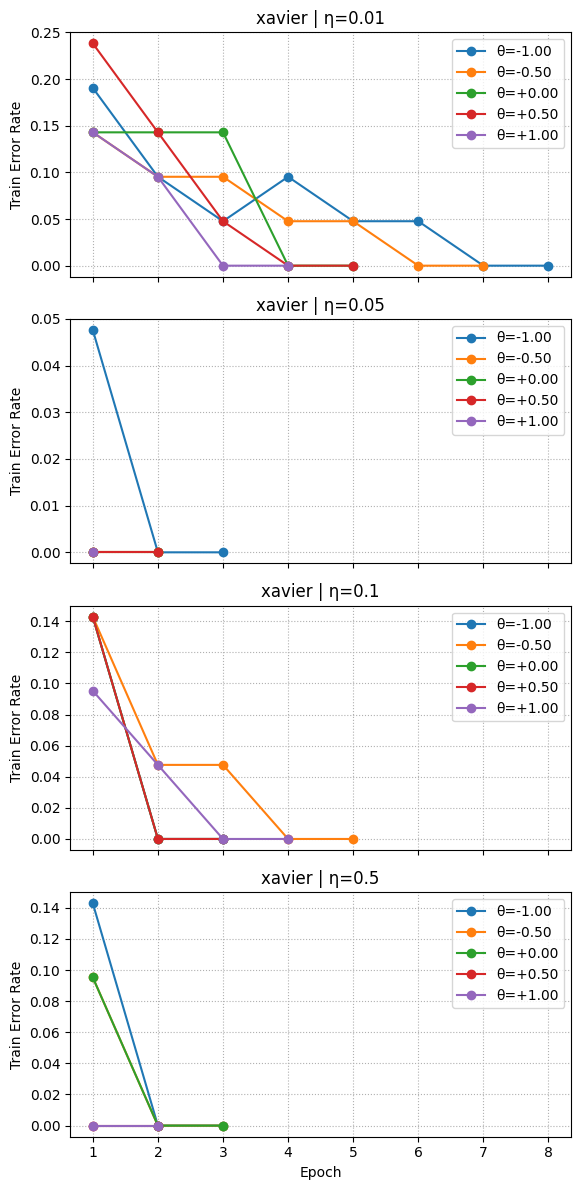

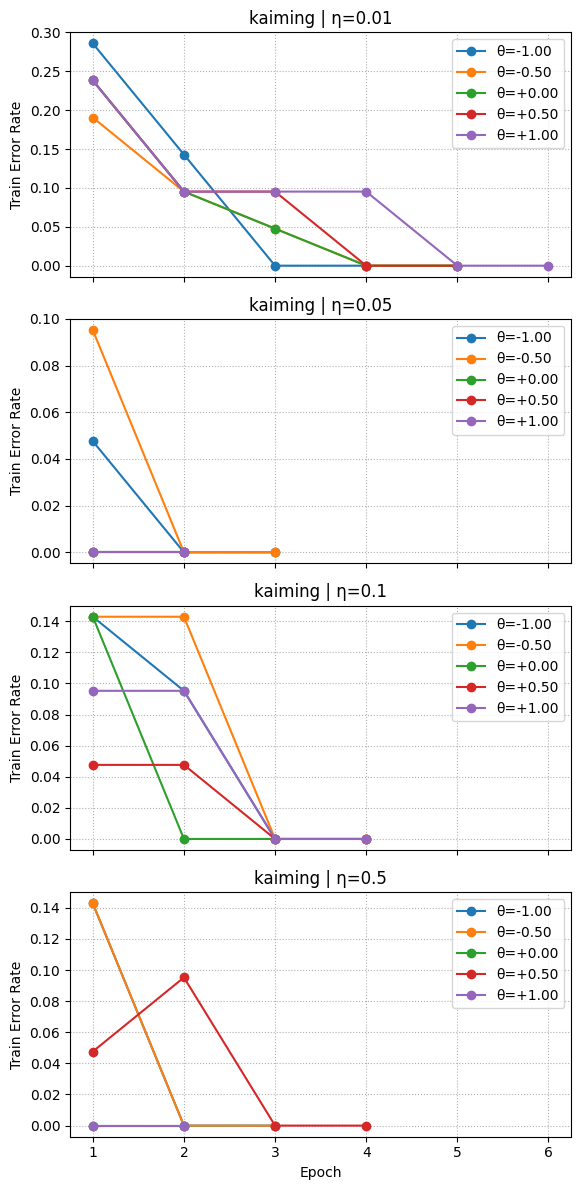

In [9]:
for mode in init_modes:
    plot_error_curves(results, mode, theta_values, eta_values, max_epochs=20)


In [10]:
print("\n=== Summary of Results ===")
print(f"{'Init':<8} {'θ':>6} {'η':>6} {'TrainErr%':>10} {'TestErr%':>10} {'ConvEpoch':>10} {'Time(s)':>10}")
for mode in init_modes:
    for rec in results[mode]:
        print(f"{mode:<8} {rec['theta']:6.2f} {rec['eta']:6.2f} "
              f"{rec['train_err']*100:10.2f} {rec['test_err']*100:10.2f} "
              f"{rec['converged_epoch']:10d} {rec['elapsed']:10.4f}")



=== Summary of Results ===
Init          θ      η  TrainErr%   TestErr%  ConvEpoch    Time(s)
zeros     -1.00   0.01       0.00      19.05          5     0.0000
zeros     -1.00   0.05       0.00       4.76          3     0.0000
zeros     -1.00   0.10       0.00       0.00          3     0.0000
zeros     -1.00   0.50       0.00       4.76          4     0.0000
zeros     -0.50   0.01       0.00       4.76          4     0.0000
zeros     -0.50   0.05       0.00       0.00          3     0.0049
zeros     -0.50   0.10       0.00       9.52          3     0.0000
zeros     -0.50   0.50       0.00       4.76          3     0.0000
zeros      0.00   0.01       0.00       4.76          3     0.0000
zeros      0.00   0.05       0.00       4.76          3     0.0000
zeros      0.00   0.10       0.00       4.76          3     0.0000
zeros      0.00   0.50       0.00       4.76          3     0.0000
zeros      0.50   0.01       0.00       4.76          4     0.0000
zeros      0.50   0.05       0.00 

# Interpretation
1. **Zeros Initialization** → slowest convergence (often needs more epochs).
2. **Random (Uniform / Normal)** → faster because symmetry is broken early.
3. **Xavier / Kaiming** → usually fastest, stable convergence, lower error.
4. **Threshold θ**:
   - Large positive θ → fewer +1 predictions (harder to classify A).
   - Large negative θ → easier +1 (risk of false positives).
5. **Learning Rate η**:
   - Too small → slow learning.
   - Too big → unstable (can overshoot).
6. You can increase `max_epochs` if some runs haven’t converged within 20 epochs.


# Adaline (Adaptive Linear Neuron)

Now we implement **Adaline**, which uses the **Delta Learning Rule** instead of the Perceptron’s binary update.

**Key differences:**
- Uses continuous output \( z = w·x + b \)
- Minimizes **Mean Squared Error (MSE)**
- Updates weights based on the continuous delta \( (y - z) \)
- Learns more smoothly and is sensitive to the learning rate \( η \)


In [11]:
def train_one_epoch_adaline(X, y, w, b, lr):
    """Perform one epoch of Adaline training using delta rule."""
    errors = []
    for xi, target in zip(X, y):
        z = np.dot(w, xi) + b
        error = target - z
        w += lr * error * xi
        b += lr * error
        errors.append(error**2)
    mse = np.mean(errors)
    return w, b, mse


def train_adaline(X, y, w_init, b_init, lr=0.01, max_epochs=100, tol=1e-4):
    """Train Adaline with continuous updates."""
    w, b = w_init.copy(), float(b_init)
    mse_list = []
    start_time = time.time()
    converged_epoch = None

    for epoch in range(1, max_epochs + 1):
        w, b, mse = train_one_epoch_adaline(X, y, w, b, lr)
        mse_list.append(mse)
        if epoch > 2 and abs(mse_list[-2] - mse) < tol:
            converged_epoch = epoch
            break

    elapsed = time.time() - start_time
    return {
        "w": w, "b": b,
        "mse_list": mse_list,
        "converged_epoch": converged_epoch or max_epochs,
        "elapsed": elapsed
    }


In [13]:
def run_adaline_experiments(train_folder="Characters-TrainSet",
                            test_folder="Characters-TestSet",
                            eta_list=[0.001, 0.01, 0.05, 0.1],
                            init_modes=["zeros","uniform","normal","xavier","kaiming"],
                            max_epochs=50):
    X_train, y_train, _ = load_dataset(train_folder)
    X_test, y_test, _ = load_dataset(test_folder)
    dim = X_train.shape[1]
    results = defaultdict(list)

    for i_mode, mode in enumerate(init_modes):
        for eta in eta_list:
            w0, b0 = init_weights(mode, dim, seed=42 + i_mode)
            res = train_adaline(X_train, y_train, w0, b0, lr=eta, max_epochs=max_epochs)
            y_train_pred = np.sign(np.dot(X_train, res["w"]) + res["b"])
            y_test_pred = np.sign(np.dot(X_test, res["w"]) + res["b"])
            train_err = np.mean(y_train_pred != y_train)
            test_err  = np.mean(y_test_pred != y_test)
            results[mode].append({
                "eta": eta,
                "train_err": train_err,
                "test_err": test_err,
                "final_mse": res["mse_list"][-1],
                "converged_epoch": res["converged_epoch"],
                "elapsed": res["elapsed"],
                "mse_list": res["mse_list"]
            })
            print(f"{mode:7s} η={eta:.3f} → train={train_err*100:5.2f}% test={test_err*100:5.2f}% conv={res['converged_epoch']} time={res['elapsed']:.3f}s")
    return results


In [14]:
eta_values = [0.001, 0.01, 0.05, 0.1]
init_modes = ["zeros", "uniform", "normal", "xavier", "kaiming"]

adaline_results = run_adaline_experiments(
    train_folder="Characters-TrainSet",
    test_folder="Characters-TestSet",
    eta_list=eta_values,
    init_modes=init_modes,
    max_epochs=30
)


zeros   η=0.001 → train= 0.00% test= 0.00% conv=30 time=0.005s
zeros   η=0.010 → train= 0.00% test= 0.00% conv=30 time=0.004s
zeros   η=0.050 → train= 0.00% test= 0.00% conv=23 time=0.003s
zeros   η=0.100 → train=23.81% test=19.05% conv=30 time=0.004s
uniform η=0.001 → train= 0.00% test= 9.52% conv=30 time=0.003s
uniform η=0.010 → train= 0.00% test= 0.00% conv=30 time=0.002s
uniform η=0.050 → train= 0.00% test= 0.00% conv=30 time=0.002s
uniform η=0.100 → train=80.95% test=80.95% conv=30 time=0.005s
normal  η=0.001 → train= 0.00% test= 0.00% conv=30 time=0.003s
normal  η=0.010 → train= 0.00% test= 0.00% conv=30 time=0.006s
normal  η=0.050 → train= 0.00% test= 0.00% conv=23 time=0.004s
normal  η=0.100 → train=23.81% test=19.05% conv=30 time=0.003s
xavier  η=0.001 → train= 4.76% test= 0.00% conv=30 time=0.005s
xavier  η=0.010 → train= 0.00% test= 0.00% conv=30 time=0.003s
xavier  η=0.050 → train= 0.00% test= 0.00% conv=26 time=0.004s
xavier  η=0.100 → train=28.57% test=28.57% conv=30 time

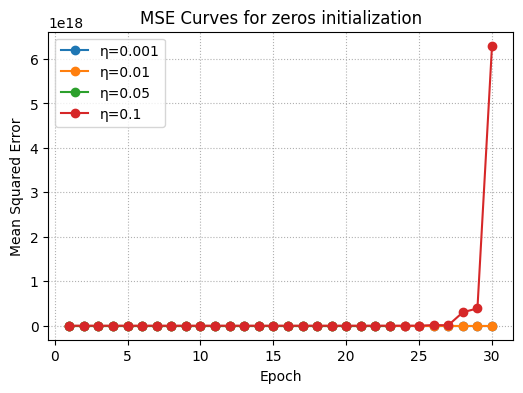

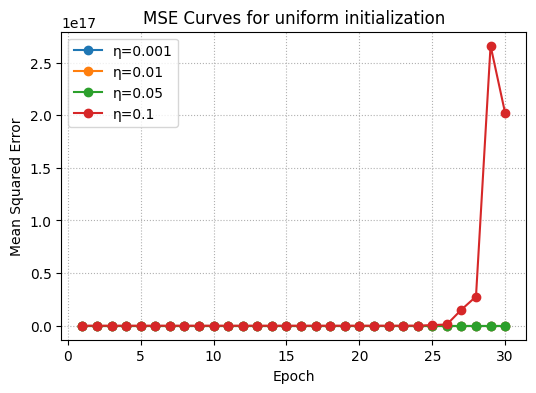

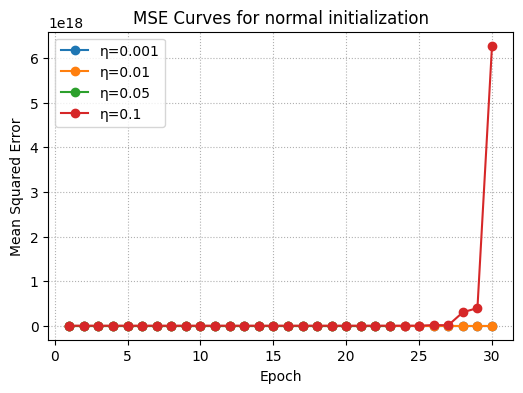

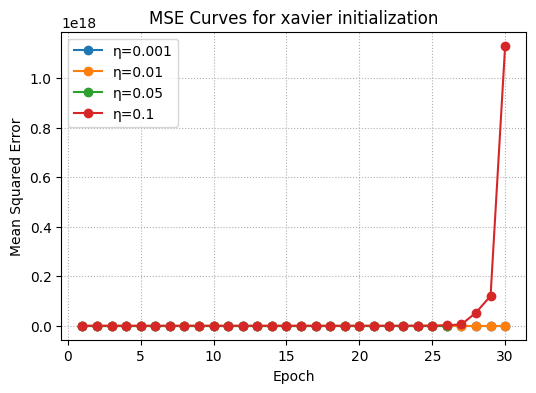

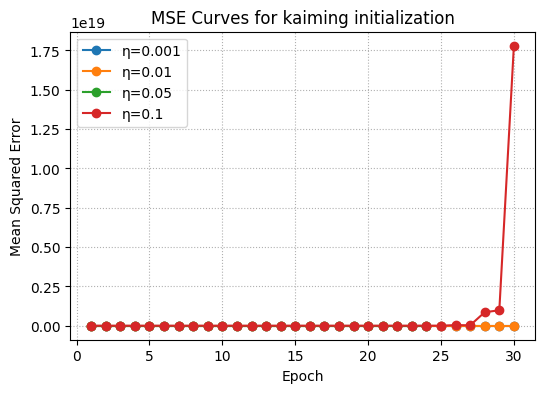

In [15]:
def plot_mse_curves(results, init_mode, eta_list, max_epochs=30):
    recs = results[init_mode]
    fig, ax = plt.subplots(figsize=(6,4))
    for rec in recs:
        epochs = np.arange(1, len(rec["mse_list"]) + 1)
        ax.plot(epochs, rec["mse_list"], marker='o', label=f"η={rec['eta']}")
    ax.set_title(f"MSE Curves for {init_mode} initialization")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean Squared Error")
    ax.grid(True, linestyle=':')
    ax.legend()
    plt.show()

for mode in init_modes:
    plot_mse_curves(adaline_results, mode, eta_values)


In [16]:
print("\n=== Perceptron vs Adaline Summary ===")
print(f"{'Init':<8} {'η':>6} {'Model':>10} {'TrainErr%':>12} {'TestErr%':>12} {'ConvEpoch':>10} {'Time(s)':>10}")

# Perceptron (from 'results') and Adaline (from 'adaline_results')
for mode in init_modes:
    perc_recs = [r for r in results[mode] if r["eta"] in eta_values and "theta" not in r]
    ada_recs  = [r for r in adaline_results[mode] if r["eta"] in eta_values]
    for (p, a) in zip(perc_recs, ada_recs):
        print(f"{mode:<8} {p['eta']:6.2f} {'Perceptron':>10} {p['train_err']*100:12.2f} {p['test_err']*100:12.2f} {p['converged_epoch']:10d} {p['elapsed']:10.4f}")
        print(f"{mode:<8} {a['eta']:6.2f} {'Adaline':>10} {a['train_err']*100:12.2f} {a['test_err']*100:12.2f} {a['converged_epoch']:10d} {a['elapsed']:10.4f}")



=== Perceptron vs Adaline Summary ===
Init          η      Model    TrainErr%     TestErr%  ConvEpoch    Time(s)


# 🔍 Comparison: Perceptron vs Adaline

| Aspect | Perceptron | Adaline |
|--------|-------------|---------|
| Update Trigger | Only when misclassified | Every sample (continuous delta) |
| Update Rule | \( w += η y x \) | \( w += η (y - z) x \) |
| Objective | Minimize classification error | Minimize Mean Squared Error (MSE) |
| Convergence | Often faster on linearly separable data | More stable, can take more epochs |
| Sensitivity to η | Moderate | High (too large η causes divergence) |
| Typical Curves | Error drops sharply then flat | Smooth MSE decrease |

**Interpretation of results:**
- Adaline generally converges smoother and has more stable weight changes.
- For noisy data or high learning rate, Adaline avoids oscillation better.
- However, it may take *more epochs* to reach near-zero error because it updates gradually.
- Perceptron may converge faster but can “bounce” due to its step updates.
